In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
filterwarnings('ignore')


Matplotlib is building the font cache; this may take a moment.


In [3]:
import matplotlib.pyplot as plt

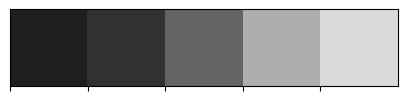

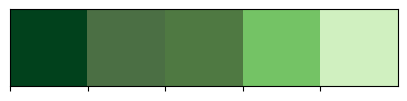

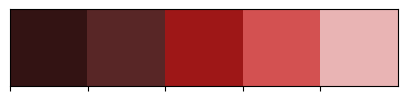

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [8]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 38.68it/s]


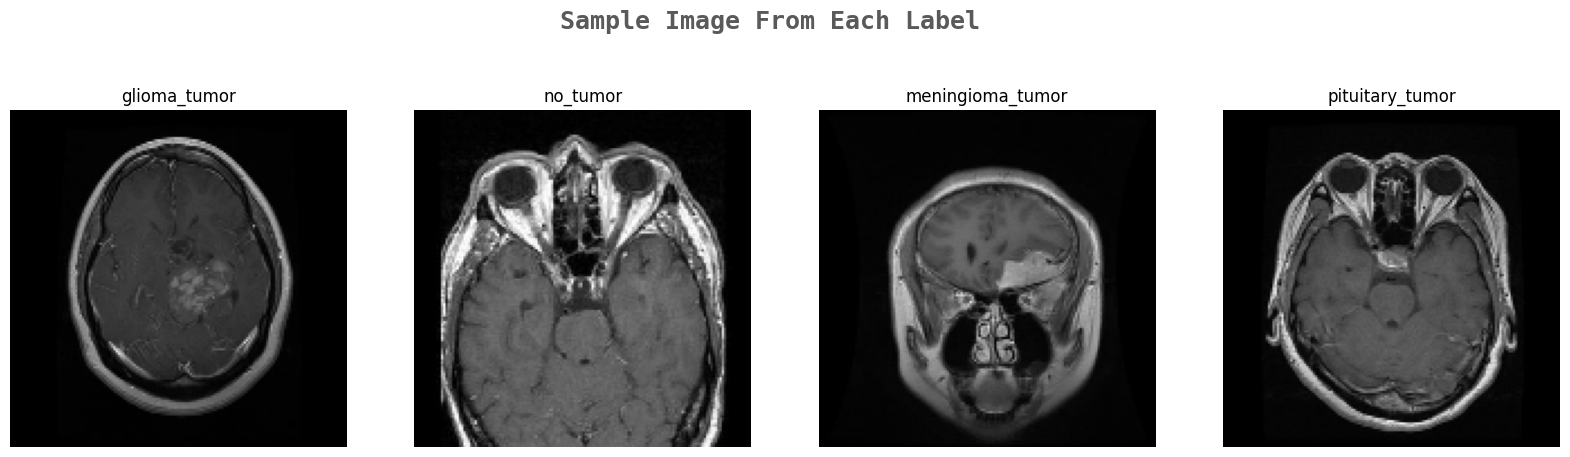

In [9]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7202 - loss: 0.6964
Epoch 1: val_accuracy improved from None to 0.87755, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8199 - loss: 0.4847 - val_accuracy: 0.8776 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9347 - loss: 0.1925
Epoch 2: val_accuracy did not improve from 0.87755
83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9311 - loss: 0.1966 - val_accuracy: 0.8299 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9554 - loss: 0.1304
Epoch 3: val_accuracy improved from 0.87755 to 0.88095, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9588 - loss: 0.1245 - val_accuracy: 0.8810 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9610 - loss: 0.1054
Epoch 4: val_accuracy improved from 0.88095 to 0.92177, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9652 - loss: 0.0967 - val_accuracy: 0.9218 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 5/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9845 - loss: 0.0567
Epoch 5: val_accuracy improved from 0.92177 to 0.96599, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9856 - loss: 0.0465 - val_accuracy: 0.9660 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 6/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9834 - loss: 0.0473
Epoch 6: val_accuracy did not improve from 0.96599
83/83 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9826 - loss: 0.0550 - val_accuracy: 0.9252 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 7/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9709 - loss: 0.0965
Epoch 7: val_accuracy did not improve from 0.96599

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9731 - loss: 0.0864 - val_accuracy: 0.9320 - val_loss: 0.1731 - learning_rate: 0.0010
Epoch 8/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9908 - loss: 0.0327
Epoch 8: val_accuracy improved from 0.96599 to 0.97279, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9932 - loss: 0.0252 - val_accuracy: 0.9728 - val_loss: 0.0834 - learning_rate: 3.0000e-04
Epoch 9/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9977 - loss: 0.0126
Epoch 9: val_accuracy did not improve from 0.97279
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9974 - loss: 0.0103 - val_accuracy: 0.9728 - val_loss: 0.0755 - learning_rate: 3.0000e-04
Epoch 10/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9966 - loss: 0.0090
Epoch 10: val_accuracy improved from 0.97279 to 0.97959, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9796 - val_loss: 0.0738 - learning_rate: 3.0000e-04
Epoch 11/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9984 - loss: 0.0065
Epoch 11: val_accuracy did not improve from 0.97959
83/83 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9728 - val_loss: 0.0930 - learning_rate: 3.0000e-04
Epoch 12/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9967 - loss: 0.0090
Epoch 12: val_accuracy improved from 0.97959 to 0.98299, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9962 - loss: 0.0087 - val_accuracy: 0.9830 - val_loss: 0.0573 - learning_rate: 3.0000e-04


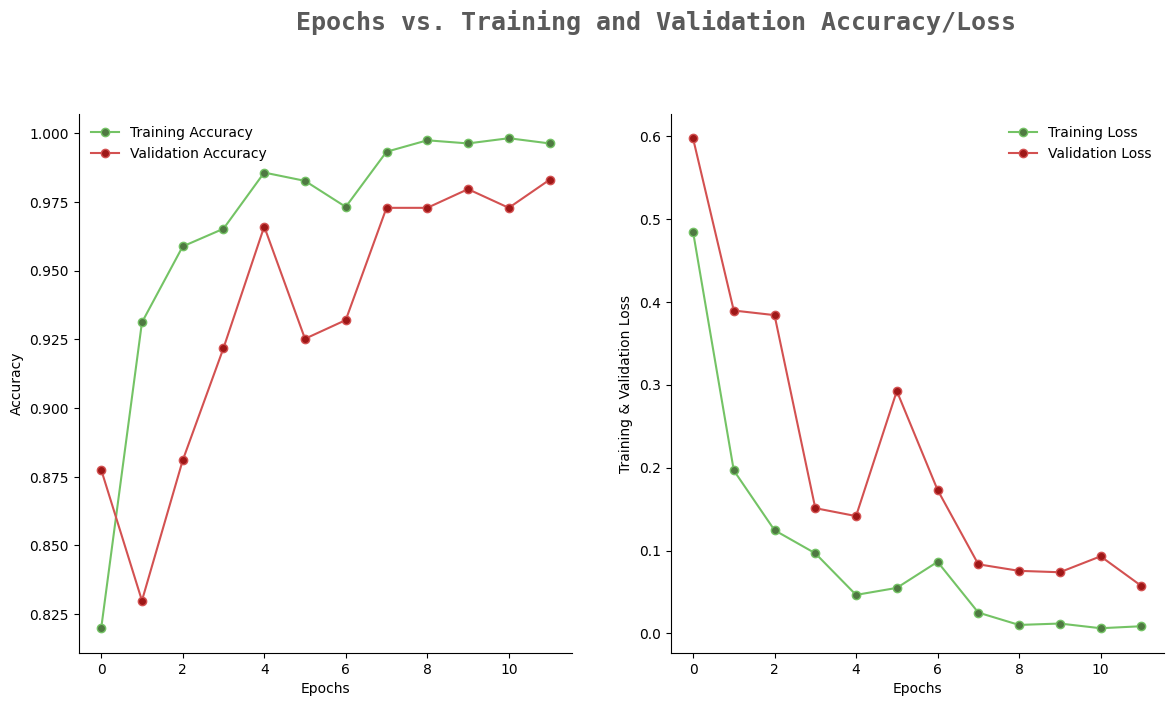

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step


In [21]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        93
           1       0.94      1.00      0.97        51
           2       0.94      0.97      0.95        96
           3       0.99      0.98      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



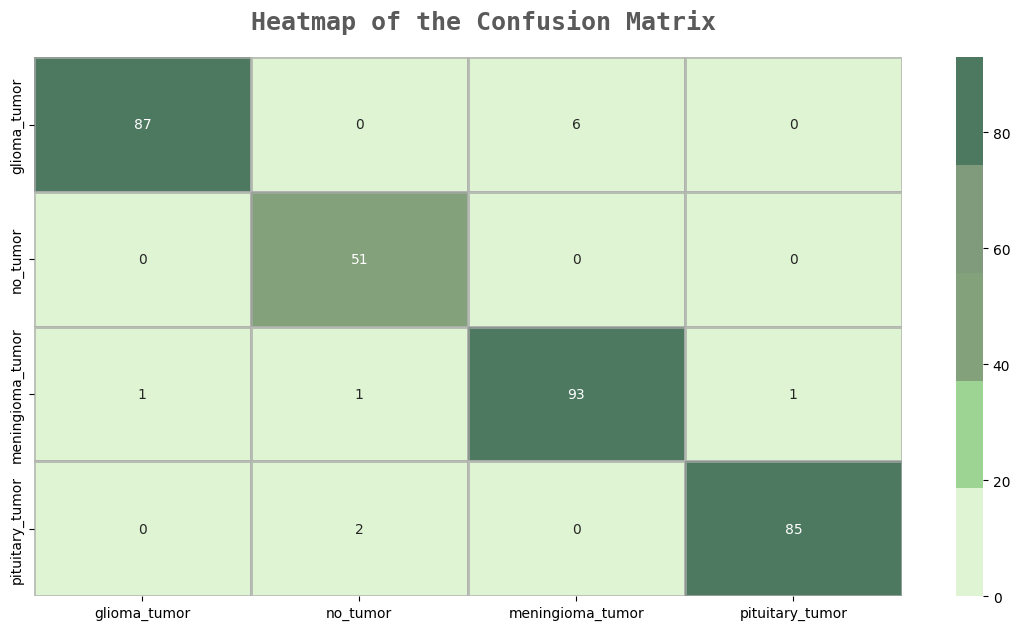

In [22]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [23]:
def img_pred(img_path):
    """
    Predict tumor type from an image file path
    
    Parameters:
    img_path (str): Path to the image file
    """
    # Read image from file path
    img = cv2.imread(img_path)
    
    # Resize the image
    img = cv2.resize(img, (150, 150))
    
    # Reshape for model input
    img = img.reshape(1, 150, 150, 3)
    
    # Make prediction
    p = model.predict(img)
    p = np.argmax(p, axis=1)[0]

    # Interpret prediction
    if p == 0:
        result = 'Glioma Tumor'
    elif p == 1:
        result = 'No Tumor'
        print('The model predicts that there is no tumor')
        return result
    elif p == 2:
        result = 'Meningioma Tumor'
    else:
        result = 'Pituitary Tumor'

    print(f'The model predicts that it is a {result}')
    return result


In [24]:
img_pred('Testing\glioma_tumor\image(2).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
The model predicts that it is a Glioma Tumor


'Glioma Tumor'